<a href="https://colab.research.google.com/github/ctivir/phd-experiments/blob/main/Dynamics_of_affectiveStates_KhanDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM - Replicating paper Dynamics of affective states during complex learning

Dataset: [LLM_Based_Math_Tutoring](https://github.com/Khan/tutoring-accuracy-dataset/blob/main/LLM_Based_Math_Tutoring.pdf)

Paper: [Dynamics of affective states during complex learning](https://doi.org/10.1016/j.learninstruc.2011.10.001)


## Import libraries

In [1]:
%pip install pip
%pip install Groq
%pip install datasets
%pip install researchpy

import re
import os
# import groq
import random
import numpy as np
import pandas as pd
import networkx as nx
import researchpy as rp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from groq import Groq
from google.colab import userdata
from google.colab import drive
from datasets import Dataset, load_dataset

os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
Mounted at /content/drive


## Run predictions

In [3]:
client = Groq(api_key = userdata.get("GROQ_API_KEY"),)
model = "llama3-8b-8192" # "gemma2-9b-it"

In [5]:
def predict(prompt: str, model: str, client: Groq = client):
    try:
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model= model, # The language model which will generate the completion.
            temperature=0.5 , # Controls randomness: lowering results in less random completions.
            max_tokens=1024, # The maximum number of tokens to generate.
            top_p=1, # Controls diversity via nucleus sampling.
            stop=None,
            stream=False, # If set, partial message deltas will be sent
        )
        return response.choices[0].message.content
    except groq.APIConnectionError as e:
        print("The server could not be reached")
        print(e.__cause__)  # an underlying Exception, likely raised within httpx.
    except groq.RateLimitError as e:
        print("A 429 status code was received; we should back off a bit.")
    except groq.APIStatusError as e:
        print("Another non-200-range status code was received")
        print(e.status_code)
        print(e.response)

In [85]:
def model1(df, states, prompt_template, model, client):
    df_model1 = []

    for c, row in df.iterrows():
        conversation = row['data']
        math_level = row['math_level']
        previous_state = ""
        timestep = 1

        for i in range(0, len(conversation), 2):
            student_response = (
                conversation[i] if conversation[i]['role'] == "user" else None
            )
            tutor_response = (
                conversation[i + 1]
                if i + 1 < len(conversation) and conversation[i + 1]['role'] == "assistant"
                else None
            )
            current_state = random.choice(states) if previous_state == "" else previous_state
            if student_response and tutor_response:
                # get the emotional state prediction from the LLM

                prompt = prompt_template.format(s_response = student_response['content'],
                                                t_response=tutor_response['content'],
                                                math_level = math_level,
                                                skill_level = random.randint(1, 5),
                                                math_ansiate = random.choice(['low', 'medium', 'high']),
                                                current_state = current_state,
                                                states = states)

                response = predict(prompt, model, client)
                # extract the predicted emotional state
                predicted_emotion_match = re.findall(r"\[(.*?)\]", response)
                predicted_emotion = (
                    predicted_emotion_match[0] if predicted_emotion_match else None
                )
                # store the user message and the predicted emotional state
                df_model1.append(
                    {
                        "student_id": c + 1,
                        "timestep": timestep,
                        "tutor_response": tutor_response,
                        "user_response": student_response,
                        "previous_state": previous_state,
                        "current_state": current_state,
                        "next_state": predicted_emotion,
                        "prompt": prompt,
                        "response": response,
                    }
                )
                # Debugging output
                print(f"Prompt:\n{prompt}\n")
                print(f"\n-----------Student {c + 1} | timestamp {timestep}-----------")
                print(f"LLM Response: {response}\n")
                print(f"Predicted Emotion: {predicted_emotion}\n")
                print(f"\n--------------------------------------------------------")
            previous_state = predicted_emotion
            timestep += 1
    df_khan_model1 = pd.DataFrame(df_model1)

    df_khan_model1.to_csv('/content/drive/MyDrive/Affective States/output/df_khan_model1_03072025', index=False)

In [79]:
def model2(df, states, prompt_template, model, client):
    df_model2 = []

    # for loop through each student / tutor conversation
    for c, conversation in enumerate(df):
        previous_state = ""
        transcript_pairs = []
        timestep = 1

        for i in range(0, len(conversation), 2):
            # access student and tutor responses
            student_response = (
                conversation[i] if conversation[i]["role"] == "user" else None
            )
            tutor_response = (
                conversation[i + 1]
                if i + 1 < len(conversation) and conversation[i + 1]["role"] == "assistant"
                else None
            )
            current_state = random.choice(states) if previous_state == "" else previous_state

            if student_response and tutor_response:
                transcript_pairs.append(
                    {
                        "student": student_response["content"],
                        "tutor": tutor_response["content"],
                    }
                )
                # Format the transcript_pairs
                formatted_transcript = "\n".join(
                    [
                        f" Student: {pair['student']}\n Tutor: {pair['tutor']}"
                        for pair in transcript_pairs
                    ]
                )
                prompt = prompt_template.format(current_state = current_state, transcript=formatted_transcript, states=states)

                # get the emotional state prediction from the LLM
                response = predict(prompt, model, client)
                # extract the predicted emotional state
                predicted_emotion_match = re.findall(r"\[(.*?)\]", response)
                predicted_emotion = (
                    predicted_emotion_match[0] if predicted_emotion_match else None
                )
                # store the user message and the predicted emotional state
                df_model2.append(
                    {
                        "student_id": c + 1,
                        "timestep": timestep,
                        "transcript": transcript_pairs,
                        "student_response": student_response,
                        "tutor_content": tutor_response,
                        "previous_state": previous_state,
                        "current_state": current_state,
                        "next_state": predicted_emotion,
                        "prompt": prompt,
                        "response": response,
                    }
                )
                # Debugging output
                print(f"Prompt:\n{prompt}\n")
                print(f"\n-----------Student {c + 1} | Message {i + 1}-----------")
                print(f"LLM Response: {response}\n")
                print(f"Predicted Emotion: {predicted_emotion}\n")
                print(f"Transcript Pairs: {transcript_pairs}\n")
                print(f"\n--------------------------------------------------------")

            previous_state = predicted_emotion
            timestep += 1

    # convert llm response to DataFrame
    df_khan_model2 = pd.DataFrame(df_model2)
    df_khan_model2.to_csv('/content/drive/MyDrive/Affective States/output/df_khan_model2_03072025', index=False)

## Load Khan Academy dataset

In [66]:
dataset = pd.read_json("https://raw.githubusercontent.com/Khan/tutoring-accuracy-dataset/refs/heads/main/CoMTA_dataset.json")
dataset.head()

# conversation_history.info()
dataset.describe().T

# dataset['data'][2]
# dataset.iloc[0].data
dataset['data'][0]

dataset.groupby(['math_level', 'expected_result']).size()

# math_level: Algebra
# expected_result: Answer Accepted
df_algebra_aa = dataset[
    (dataset['math_level'] == 'Algebra') &
    (dataset['expected_result'] == 'Answer Accepted')
]
print(df_algebra_aa.head())

# expected_result: Answer Not Accepted
df_algebra_ana = dataset[
    (dataset['math_level'] == 'Algebra') &
    (dataset['expected_result'] == 'Answer Not Accepted')
]
# print(df_algebra_ana.head())
# pd.DataFrame(df_algebra_aa['data'][:3]

    expected_result math_level  \
6   Answer Accepted    Algebra   
7   Answer Accepted    Algebra   
9   Answer Accepted    Algebra   
11  Answer Accepted    Algebra   
18  Answer Accepted    Algebra   

                                                 data  test_id  
6   [{'role': 'user', 'content': 'I need assistanc...        7  
7   [{'role': 'user', 'content': 'I'm 30 years old...        8  
9   [{'role': 'user', 'content': 'Can you provide ...       10  
11  [{'role': 'user', 'content': 'I need 10 practi...       12  
18  [{'role': 'user', 'content': 'how can I factor...       19  


In [75]:
dataset.groupby(['math_level', 'expected_result']).size()

math_level    expected_result    
Algebra       Answer Accepted        21
              Answer Not Accepted    24
Calculus      Answer Accepted        18
              Answer Not Accepted    17
Elementary    Answer Accepted        33
              Answer Not Accepted    19
Geometry      Answer Accepted        17
              Answer Not Accepted     9
Trigonometry  Answer Accepted        19
              Answer Not Accepted    11
dtype: int64

In [76]:
states = [
    "boredom",
    "engagement",
    "confusion",
    "frustration",
    "delight",
    "surprise",
    "neutral",
]

prompt_exper1_2 = """
A student is interacting with an intelligent tutoring system on a {math_level} problem-solving task with the following:
1. Problem-solving skill level: {skill_level}
2. Math anxiety level: {math_ansiate}
3. Current emotional state: [{current_state}]
The system adapts its guidance based on the student's responses and emotional state.
Here’s the dialogue:
Student: {s_response}\n
Tutor: {t_response}\n

Based on the conversation, predict the student's most likely next emotional state.
Choose one from the following options: {states}
- Format: Write the answer inside square brackets (e.g., [Emotion]).
- Reasoning: Briefly explain why this emotional state is the most likely.

"""

prompt_exper1_1 = """
A student is using an intelligent tutoring system on math problem solving, their initial emotion state is [{current_state}].
The system adjusts its guidance based on the student's responses and their current emotion state.\n
Here's the dialog: \n - Student: {s_response}\n - Tutor: {t_response}\n
Based on their transcript, which emotional state is the student most likely to feel next?
Choose only one from the following options: {states}
- Format: Write the answer inside square brackets.
- Reasoning: Briefly explain why this emotional state is the most likely.
"""

prompt_exper1 = """
A student is using an intelligent tutoring system on math problem solving.\n
The system adjusts its guidance based on the student's responses.\n
Here's the dialog: \n'Student: {s_response}\nTutor: {t_response}'\n
Based on their transcript, which emotional state is the student most likely to feel next?
Choose only one from the following options: {states}\n
- Format: Write the answer inside square brackets.\n
- Reasoning: Briefly explain why this emotional state is the most likely.
"""

prompt_exper2_1 = """
A student is using an intelligent tutoring system on math problem solving.
The system adjusts its guidance based on the student's responses and their current emotion state.\n
Here's the
- student emotion state: [{current_state}], and
- the dialog: \n{transcript} \n
Based on their transcript, which emotional state is the student most likely to feel next?
Choose only one from the following options: {states}
- Format: Write the answer inside square brackets.
- Reasoning: Briefly explain why this emotional state is the most likely.
"""

prompt_exper2 = """
A student is using an intelligent tutoring system on math problem solving.\n
The system adjusts its guidance based on the student's responses.\n
Here's the dialog: \n'{transcript}'\n
Based on their transcript, which emotional state is the student most likely to feel next?
Choose only one from the following options: {states}\n
- Format: Write the answer inside square brackets.\n
- Reasoning: Briefly explain why this emotional state is the most likely.
"""

### Experiment 1:
LLM Emotional state judgement: previous student's and tutor's response

In [83]:
dataset[['math_level', 'data']][:1]

,math_level,data
0,Elementary,"[{'role': 'user', 'content': 'I'm struggling w..."


In [89]:
# Conversation data of algebra skills with answer accepted
# df_algebra_aa = df_algebra_aa["data"][:50]
# df_algebra = dataset["data"]
# model1(dataset['data'], states, prompt_exper1, model, client)
model1(dataset[:1], states, prompt_exper1_2, model, client) # prompt where previous state is randomly initialized

Prompt:

A student is interacting with an intelligent tutoring system on a Elementary problem-solving task with the following:
1. Problem-solving skill level: 5
2. Math anxiety level: low
3. Current emotional state: [frustration]
The system adapts its guidance based on the student's responses and emotional state.
Here’s the dialogue:
Student: I'm struggling with multiplying decimal numbers, can you guide me through the process?

Tutor: Absolutely! Let's begin with a basic problem. How about \(0.2 \times 0.3\)? Try to solve it and let me know your answer. Remember, you can initially treat the decimals as if they were whole numbers!


Based on the conversation, predict the student's most likely next emotional state.
Choose one from the following options: ['boredom', 'engagement', 'confusion', 'frustration', 'delight', 'surprise', 'neutral']
- Format: Write the answer inside square brackets (e.g., [Emotion]).
- Reasoning: Briefly explain why this emotional state is the most likely.




--

### Experiment 2
LLM Emotional state judgement: all diologue betwen student and tutor

In [10]:
# model2(dataset["data"], states, prompt_exper2, model, client)
# model2(dataset["data"], states, prompt_exper2_1, model, client)

Streaming output truncated to the last 5000 lines.

--------------------------------------------------------
Prompt:

A student is using an intelligent tutoring system on math problem solving.
The system adjusts its guidance based on the student's responses and their current emotion state.

Here's the
- student emotion state: [frustration], and
- the dialog: 
 Student: Given the function f(x) = -2[x] + 8, where [x] represents the floor function (greatest integer less than or equal to x), can you determine the value of f(-1.8)?

4
6
10
12
 Tutor: I see. Let's break this down step by step. First, can you tell me what the floor function of -1.8 is? 

Based on their transcript, which emotional state is the student most likely to feel next?
Choose only one from the following options: ['boredom', 'engagement', 'confusion', 'frustration', 'delight', 'surprise', 'neutral']
- Format: Write the answer inside square brackets.
- Reasoning: Briefly explain why this emotional state is the most likel

## Analysis

In [62]:
#  Load llm responses of experiments 1 and 2
df_exper1 = pd.read_csv('/content/drive/MyDrive/Affective States/output/df_khan_model1_02272025', delimiter=",")
df_exper2 = pd.read_csv('/content/drive/MyDrive/Affective States/output/df_khan_model2_02282025', delimiter=",")

# previous state true
df_model1 = pd.read_csv('/content/drive/MyDrive/Affective States/output/df_khan_model1_03062025', delimiter=",")
df_model2 = pd.read_csv('/content/drive/MyDrive/Affective States/output/df_khan_model2_03062025', delimiter=",") #llama3-70b-8192

In [64]:
df_model1.columns

Index(['student_id', 'timestep', 'tutor_response', 'user_response',
       'previous_state', 'current_state', 'next_state', 'prompt', 'response'],
      dtype='object')

In [65]:
df_exper1['response'][:3]

,response
0,[engagement]\n\nThe student is actively seekin...
1,[confusion]\n\nThe tutor is pointing out the s...
2,"[engagement]\n\nThe student asks a question, w..."


In [13]:
def clean_data(df, cols):
  for i in cols:
        if i in df.columns:
          df[i] = df[i].str.lower()
        else:
          print(f"Column '{i}' not found in the DataFrame.")
  return df

In [20]:
dfs = {
    # 'df_exper1': df_exper1,
    # 'df_exper2': df_exper2,
    'df_model1 03/06/2025': df_model1,
    'df_model2 03/06/2025': df_model2
}

cols = ['previous_state', 'next_state']
df_exper1 = clean_data(df_exper1, df_exper1[cols])
df_exper2 = clean_data(df_exper2, df_exper2[cols])
df_model1 = clean_data(df_model1, df_model1[['current_state', 'next_state']])
df_model2 = clean_data(df_model2, cols=df_model2[['current_state', 'next_state']])

In [21]:
for name, df in dfs.items():
    duplicate = df['current_state'] == df['next_state']
    print(f"DataFrame name: {name}")
    print("*" * 70)
    print(f"Shape: {df.shape}\nOn average there were {round(len(df)/df['student_id'].nunique(), 0)}"
        f" total judgment for each student (SD={round(df['student_id'].std(), 0)})\n")
    print(f"Count of self-transitions: {df[~duplicate].shape[0]}\n")

    print(df.groupby('current_state')['student_id'].agg(['mean', 'std']))
    print("\n")

DataFrame name: df_model1 03/06/2025
**********************************************************************
Shape: (917, 9)
On average there were 5.0 total judgment for each student (SD=57.0)

Count of self-transitions: 477

                     mean        std
current_state                       
boredom         99.700000  49.348492
confusion       98.053435  55.758864
delight         89.488095  56.836797
engagement      93.409660  56.655521
frustration     97.689655  60.387987
neutral         71.473684  61.216380
surprise       103.666667  47.587975


DataFrame name: df_model2 03/06/2025
**********************************************************************
Shape: (917, 10)
On average there were 5.0 total judgment for each student (SD=57.0)

Count of self-transitions: 477

                     mean        std
current_state                       
boredom         99.208333  52.821257
confusion       96.032258  55.449374
delight         82.553846  57.613483
engagement      92.439759  55

In [22]:
for name, df in dfs.items():
  print(f"{name}\n{df_model1.describe().T}\n")

df_model1 03/06/2025
            count       mean        std  min   25%   50%    75%    max
student_id  917.0  93.514722  56.674115  1.0  43.0  94.0  140.0  188.0
timestep    917.0   4.448201   3.623792  1.0   2.0   3.0    6.0   21.0

df_model2 03/06/2025
            count       mean        std  min   25%   50%    75%    max
student_id  917.0  93.514722  56.674115  1.0  43.0  94.0  140.0  188.0
timestep    917.0   4.448201   3.623792  1.0   2.0   3.0    6.0   21.0



In [23]:
for name, df in dfs.items():
  summary = rp.summary_cont(df.groupby('next_state')['student_id'])
  print(f"{name}\nSumary of model 1 \n{summary}")
  print(f"{70*'*'}")



df_model1 03/06/2025
Sumary of model 1 
               N     Mean       SD       SE  95% Conf.  Interval
next_state                                                      
confusion    116  99.8534  56.3445   5.2315    89.4909  110.2160
delight       65  89.0615  59.8965   7.4292    74.2199  103.9032
engagement   690  93.0580  56.3565   2.1455    88.8456   97.2704
frustration   43  94.0000  58.5625   8.9307    75.9771  112.0229
neutral        3  43.0000  25.9808  15.0000   -21.5398  107.5398
**********************************************************************


df_model2 03/06/2025
Sumary of model 1 
               N      Mean       SD      SE  95% Conf.  Interval
next_state                                                      
confusion    113   99.2301  56.2836  5.2947    88.7393  109.7209
delight       44   66.9318  58.8891  8.8779    49.0279   84.8357
engagement   607   92.3048  55.1168  2.2371    87.9113   96.6982
frustration  152  101.6711  60.4160  4.9004    91.9889  111.3532


In [24]:
def compute_mean_sd(df, cols):
  data = pd.get_dummies(df, columns = cols, prefix=['state'], dtype=int)
  numeric = data.select_dtypes(include=np.number)
  result = numeric.agg(['sum', 'mean', 'std']).T
  return result

compute_mean_sd(df_model1, ['current_state'])

,sum,mean,std
student_id,85753.0,93.514722,56.674115
timestep,4079.0,4.448201,3.623792
state_boredom,20.0,0.021810,0.146143
state_confusion,131.0,0.142857,0.350118
state_delight,84.0,0.091603,0.288622
state_engagement,559.0,0.609597,0.488107
state_frustration,58.0,0.063250,0.243544
state_neutral,38.0,0.041439,0.199413
state_surprise,27.0,0.029444,0.169139


In [61]:
compute_mean_sd(df_model1, ['next_state'])

,sum,mean,std
student_id,85753.0,93.514722,56.674115
timestep,4079.0,4.448201,3.623792
state_confusion,116.0,0.126499,0.332593
state_delight,65.0,0.070883,0.256770
state_engagement,690.0,0.752454,0.431822
state_frustration,43.0,0.046892,0.211523
state_neutral,3.0,0.003272,0.057135


In [13]:
# transition_count = df_model1.groupby(['current_state', 'next_state'])['student_id'].nunique().reset_index(name="N")
transition = df_model1.loc[:, ('current_state', 'next_state')]
transition['transition_name'] = transition['current_state'].astype(str) + " --> " + transition['next_state'].astype(str)

transition
# data = pd.get_dummies(transition_count, columns = ['transition_name'], prefix=['state'], dtype=int)
compute_mean_sd(transition, ['transition_name'])

,sum,mean,std
state_boredom --> engagement,20.0,0.021810,0.146143
state_confusion --> confusion,3.0,0.003272,0.057135
state_confusion --> delight,3.0,0.003272,0.057135
state_confusion --> engagement,99.0,0.107961,0.310500
state_confusion --> frustration,25.0,0.027263,0.162937
state_confusion --> neutral,1.0,0.001091,0.033023
state_delight --> confusion,10.0,0.010905,0.103913
state_delight --> delight,16.0,0.017448,0.131006
state_delight --> engagement,57.0,0.062159,0.241576
state_delight --> frustration,1.0,0.001091,0.033023


In [25]:
transition_count = df_model1[['current_state', 'next_state']].copy()
transition_count['transition_name'] = transition_count['current_state'].astype(str) + " --> " + transition_count['next_state'].astype(str)
# transition_count
result = compute_mean_sd(transition_count, ['transition_name'])
result.columns = ['N', 'M', 'SD']

result['t'] = result.apply(lambda row: row['M'] / (row['SD'] / np.sqrt(row['N'])) if row['SD'] > 0 else 0, axis=1)
result['df'] = result['N'].apply(lambda x: x - 1 if x > 1 else 0) # N - 1
result['p'] = result.apply(lambda row: stats.t.sf(abs(row['t']), row['df']) * 2 if row['df'] > 0 else 1, axis=1)
result['d'] = result.apply(lambda row: row['M'] / row['SD'] if row['SD'] > 0 else 0, axis=1)

result[['N', 'df']] = result[['N', 'df']].astype(int)
result.round(3)

,N,M,SD,t,df,p,d
state_boredom --> engagement,20,0.022,0.146,0.667,19,0.513,0.149
state_confusion --> confusion,3,0.003,0.057,0.099,2,0.930,0.057
state_confusion --> delight,3,0.003,0.057,0.099,2,0.930,0.057
state_confusion --> engagement,99,0.108,0.311,3.460,98,0.001,0.348
state_confusion --> frustration,25,0.027,0.163,0.837,24,0.411,0.167
state_confusion --> neutral,1,0.001,0.033,0.033,0,1.000,0.033
state_delight --> confusion,10,0.011,0.104,0.332,9,0.748,0.105
state_delight --> delight,16,0.017,0.131,0.533,15,0.602,0.133
state_delight --> engagement,57,0.062,0.242,1.943,56,0.057,0.257
state_delight --> frustration,1,0.001,0.033,0.033,0,1.000,0.033


## Data Visualization

In [26]:
def plot_series(df, x_label, idx=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = df['timestep']
  ys = df['count']

  plt.plot(xs, ys, label=x_label, color=palette[idx % len(palette)])


def matrix(df, idx, cols, vals):
    matrix = df.pivot(
    index=idx,
    columns=cols,
    values=vals,
    ).fillna("-")
    # print(khan_matrix_prob)
    # print("\n")
    return pd.DataFrame(matrix)


def transition_visualization(df, x, y, category):
  plt.figure(figsize=(12, 6))
  sns.lineplot(x=x, y=y, hue=category, data=df, palette='tab10')

  # customize the plot
  plt.title('Student Emotional Trajectory')
  plt.xlabel('Timesteps')
  plt.ylabel('Students')
  # plt.xticks(rotation=90)
  plt.legend(title = category)
  plt.grid(True)
  return plt.show()


def heatmap(df, x_label: str, y_label: str):
  plt.figure(figsize=(6, 4))
  sns.heatmap(df, annot=True, cmap="Reds", fmt=".2f", linewidths=0.5)
  # Labels and formatting
  plt.title("Transition Matrix")
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  return plt.show()

def network_graph(data, ps, ns, prob):

    states = set(data[ps]).union(set(data[ns]))

    G = nx.MultiDiGraph()
    G.add_nodes_from(states)

    for i, row in data.iterrows():
            G.add_edge(
                row[ps],
                row[ns],
                key=i,
                prob=row[prob],
            )

    # pos = nx.spring_layout(G, seed=14) circular
    pos = nx.circular_layout(G, scale=1)

    # Plot the graph
    plt.figure(figsize=(8, 6))

    nx.draw_networkx_nodes(G, pos, node_color="orange", node_size=1250)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    for u, v, key, edge_data in G.edges(keys=True, data=True):
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            edge_color=sns.color_palette('Dark2'),
            connectionstyle=f"arc3, rad=0.15",  # curvature for distinct edges
            width=2,
            arrowstyle="-|>",
            arrows=True,
            arrowsize=15,
            min_target_margin=15,
        )

    # Add edge labels (probabilities)
    edge_labels = {
        (u, v, key): f"({edge_data['prob'] * 100:.1f}%)"
        for u, v, key, edge_data in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8, font_color="black", label_pos=0.8
    )

    # debugging: print edges
    print("All edges (with attributes):", list(G.edges(keys=True, data=True)))

    plt.title(f"State Transition Graph")
    plt.show()

In [27]:
def comp_model(df1, df2, t, ns):
  count1 = df1.groupby([t, ns]).size().reset_index(name='count')
  count2 = df2.groupby([t, ns]).size().reset_index(name='count')

  all = count1.merge(count2, on=[t, ns], suffixes=('_exper1', '_exper2'))
  fig, ax = plt.subplots(figsize=(10, 6))

  bar_width = 0.2
  x_positions = np.arange(len(all[t].unique()))

  colors = sns.color_palette('Dark2', n_colors=len(all[ns].unique()))

  for i, (series_name, series) in enumerate(all.groupby(ns)):
      x = np.arange(len(series))  # X positions

      ax.bar(x + (i * bar_width), series['count_exper1'], width=bar_width, label=f'{series_name} - Model 1', alpha=0.7, color=colors[i])
      ax.bar(x + (i * bar_width), series['count_exper2'], width=bar_width, label=f'{series_name} - Model 2', alpha=0.3, color=colors[i])

  ax.set_xlabel('Timestep')
  ax.set_ylabel('Total students')
  ax.set_title('Comparison of two models')

  ax.set_xticks(x_positions)
  ax.set_xticklabels(all['timestep'].unique(), rotation=45)

  ax.legend(title='Next State',  bbox_to_anchor=(1, 1), loc='upper left')

  plt.tight_layout()
  plt.show()


In [ ]:
comp_model(df_exper1, df_exper2,'timestep', 'next_state')
comp_model(df_model1, df_model2,'timestep', 'next_state')
# comp_model(df_exper1, df_model1,'timestep', 'next_state')

In [ ]:
for name, df in dfs.items():
  count = df.groupby(['timestep', 'next_state']).size().reset_index(name='count')
  fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
  df_sorted = count.sort_values('timestep', ascending=True)
  for i, (series_name, series) in enumerate(df_sorted.groupby('next_state')):
    plot_series(series, series_name, i)
    fig.legend(title='Next state', bbox_to_anchor=(1, 1), loc='upper left')
  sns.despine(fig=fig, ax=ax)
  plt.title(f'{name}: Emotion trajectory over the timestep')
  plt.xlabel('Timestep')
  plt.ylabel('Total students')

In [ ]:
matrix(df_exper1, 'student_id', 'timestep', 'next_state')
matrix(df_exper2, 'student_id', 'timestep', 'next_state')
matrix(df_model1, 'student_id', 'timestep', 'next_state')
matrix(df_model2, 'student_id', 'timestep', 'next_state')

timestep,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
student_id,,,,,,,,,,,,,,,,,,,,,
1,engagement,confusion,engagement,engagement,engagement,engagement,frustration,engagement,delight,delight,...,-,-,-,-,-,-,-,-,-,-
2,engagement,engagement,engagement,engagement,engagement,engagement,engagement,delight,delight,delight,...,delight,delight,engagement,-,-,-,-,-,-,-
3,frustration,frustration,engagement,engagement,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,frustration,engagement,engagement,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
5,engagement,engagement,engagement,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,engagement,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
185,engagement,confusion,frustration,confusion,frustration,engagement,frustration,frustration,engagement,-,...,-,-,-,-,-,-,-,-,-,-
186,engagement,engagement,confusion,frustration,frustration,frustration,frustration,frustration,confusion,frustration,...,engagement,confusion,frustration,-,-,-,-,-,-,-


In [ ]:
for name, df in dfs.items():
  print(f"{name}\n")
  transition_visualization(df, 'timestep', 'student_id', 'next_state')

## Compute probability


In [47]:
def compute_probability(df, ps, ns, exclude_self_transition=False):
    """
    Compute the probability of transitioning from a previous state to a next state.

    Parameters:
        df (pd.DataFrame): DataFrame containing state transitions.
        ps (str): Column name for the previous state.
        ns(str): Column name for the next state.
        exclude_self_transition (bool): If True, rows where p_state equals n_state are excluded.

    Returns:
        pd.DataFrame: DataFrame containing:
            - ps: previous state,
            - ns: next state,
            - transition_count: number of transitions from p_state to n_state,
            - previous_state_count: total number of occurrences of p_state,
            - probability: transition_count divided by previous_state_count.
            - next_state_count: total number of occurrences of n_state,
            - likelihood: next_state_count divided by total number of student interactions
    """
    # Remove rows with missing previous state.
    # df = df[df[ps].notna()]

    # Exclude self-transitions if required.
    if exclude_self_transition:
        df = df[df[ps] != df[ns]]

    # Compute counts for each transition and for each previous state.
    transition_count = (
        df.groupby([ps, ns])
          .size()
          .reset_index(name='transition_count')
    )
    previous_state_count = (
        df.groupby(ps)
          .size()
          .reset_index(name='previous_state_count')
    )

    next_state_count = (
        df.groupby(ns)
          .size()
          .reset_index(name='next_state_count')
    )

    # Merge and calculate transition probabilities.
    result = transition_count.merge(previous_state_count, on=ps, how='left')
    result['probability'] = result['transition_count'] / result['previous_state_count']

    # Merge and calculate transition likelihood.
    result = result.merge(next_state_count, on=ns, how='left')
    result['likelihood'] = result['transition_count'] / df_model1['student_id'].count()

    return result

In [49]:
compute_probability(df_model1, 'current_state', 'next_state', exclude_self_transition=True)

,current_state,next_state,transition_count,previous_state_count,probability,next_state_count,likelihood
0,boredom,engagement,20,20,1.000000,273,0.021810
1,confusion,delight,3,128,0.023438,49,0.003272
2,confusion,engagement,99,128,0.773438,273,0.107961
3,confusion,frustration,25,128,0.195312,40,0.027263
4,confusion,neutral,1,128,0.007812,2,0.001091
5,delight,confusion,10,68,0.147059,113,0.010905
6,delight,engagement,57,68,0.838235,273,0.062159
7,delight,frustration,1,68,0.014706,40,0.001091
8,engagement,confusion,89,142,0.626761,113,0.097056
9,engagement,delight,39,142,0.274648,49,0.042530


### Compute probability and likelihood

D'Mello - Study 1 [ total instances 1796 ]
28 participants

(M = .160, SD = .140),
confusion (M = .180, SD = .127),
engagement/flow (M = .199, SD = .161),
frustration (M = .114, SD = .107), and
neutral (M = .288, SD = .248) were on par and significantly greater than
delight (M = .032, SD = .038) and
surprise (M = .027, SD = .028), which were equivalent to each other

- N - the number of unique students transiting from previous state to next state
- M - Mean probability
- SD - Standard Deviation per previous state
- t - t-statistic tests whether transition probabilities are significantly different from zero
- df - adjusts based on the sample size
- p - p-value computes the significance of the transition probability
- d - Cohen’s d for standardizing effect size

In [30]:
def compute_transition_statistics(df, ps, ns, exclude_self_transition=False):

    # Exclude self-transitions if required.
    if exclude_self_transition:
        df = df[df[ps] != df[ns]]

    data = df[[ps, ns]].copy()
    data['transition_name'] = data[ps].astype(str) + " --> " + data[ns].astype(str)
    # transition_count
    result = compute_mean_sd(data, ['transition_name'])
    result.columns = ['N', 'M', 'SD']

    # result['t'] = result.apply(lambda row: row['M'] / (row['SD'] / np.sqrt(row['N'])) if row['SD'] > 0 else 0, axis=1)
    # result['df'] = result['N'].apply(lambda x: x - 1 if x > 1 else 0) # N - 1
    # result['p'] = result.apply(lambda row: stats.t.sf(abs(row['t']), row['df']) * 2 if row['df'] > 0 else 1, axis=1)
    # result['d'] = result.apply(lambda row: row['M'] / row['SD'] if row['SD'] > 0 else 0, axis=1)

    result['t'] = result['M'] / (result['SD'] / np.sqrt(result['N']))
    result['df'] = result['N'] - 1
    result['p'] = 2 * (1 - stats.t.cdf(np.abs(result['t'] ), result['df'] ))
    result['d']  = result['M'] / result['SD']

    result[['N', 'df']] = result[['N', 'df']].astype(int)

    return result

In [50]:
compute_transition_statistics(df_model2, 'current_state', 'next_state', exclude_self_transition=True)

,N,M,SD,t,df,p,d
state_boredom --> engagement,24,0.050314,0.218823,1.126436,23,0.271597,0.229933
state_confusion --> engagement,45,0.094340,0.292608,2.162793,44,0.036033,0.322410
state_confusion --> frustration,78,0.163522,0.370230,3.900789,77,0.000204,0.441677
state_confusion --> neutral,1,0.002096,0.045787,0.045787,0,NaN,0.045787
state_delight --> confusion,2,0.004193,0.064684,0.091670,1,0.941804,0.064821
state_delight --> engagement,55,0.115304,0.319724,2.674550,54,0.009881,0.360636
state_engagement --> confusion,59,0.123690,0.329573,2.882758,58,0.005521,0.375303
state_engagement --> delight,34,0.071279,0.257560,1.613695,33,0.116117,0.276746
state_engagement --> frustration,23,0.048218,0.214452,1.078311,22,0.292576,0.224843
state_frustration --> confusion,48,0.100629,0.301153,2.315031,47,0.025027,0.334146


In [52]:
# exper1_transition_prob = compute_probability(df_exper1, 'previous_state', 'next_state', exclude_self_transition=True)
# exper2_transition_prob = compute_probability(df_exper2, 'previous_state', 'next_state', exclude_self_transition=True)
# Date 03/06/2025
model1_prob = compute_probability(df_model1, 'current_state', 'next_state', exclude_self_transition=True)
model2_prob = compute_probability(df_model2, 'current_state', 'next_state', exclude_self_transition=True)

In [ ]:
dfs_prob = {
    'exper1_transition_prob': exper1_transition_prob,
    'exper2_transition_prob': exper2_transition_prob
}

for name, df in dfs_prob.items():
  matrix_prob = df.pivot(index='previous_state', columns='next_state', values='probability').fillna(0)
  print(f"{70*'*'}\n{name}\n{70*'*'}\n{matrix_prob}\n")
  heatmap(matrix_prob, 'Next State', 'Previous State')

**********************************************************************
model1_prob
**********************************************************************
next_state     confusion   delight  engagement  frustration   neutral
current_state                                                        
boredom         0.000000  0.000000    1.000000     0.000000  0.000000
confusion       0.000000  0.023438    0.773438     0.195312  0.007812
delight         0.147059  0.000000    0.838235     0.014706  0.000000
engagement      0.626761  0.274648    0.000000     0.098592  0.000000
frustration     0.145455  0.072727    0.763636     0.000000  0.018182
neutral         0.081081  0.054054    0.864865     0.000000  0.000000
surprise        0.111111  0.037037    0.851852     0.000000  0.000000



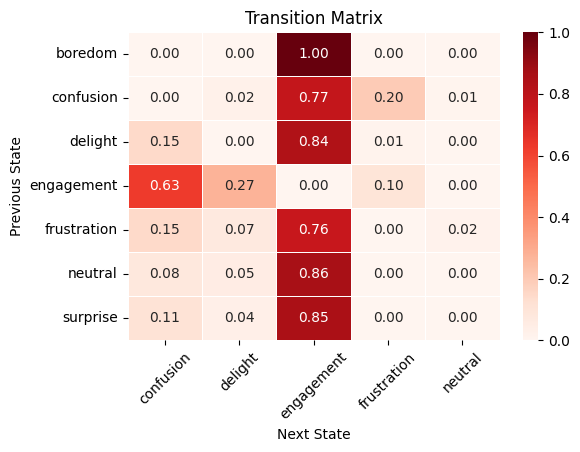

**********************************************************************
model2_prob
**********************************************************************
next_state     confusion   delight  engagement  frustration   neutral
current_state                                                        
boredom         0.000000  0.000000    1.000000     0.000000  0.000000
confusion       0.000000  0.000000    0.362903     0.629032  0.008065
delight         0.035088  0.000000    0.964912     0.000000  0.000000
engagement      0.508621  0.293103    0.000000     0.198276  0.000000
frustration     0.470588  0.009804    0.519608     0.000000  0.000000
neutral         0.064516  0.032258    0.870968     0.032258  0.000000
surprise        0.086957  0.000000    0.913043     0.000000  0.000000



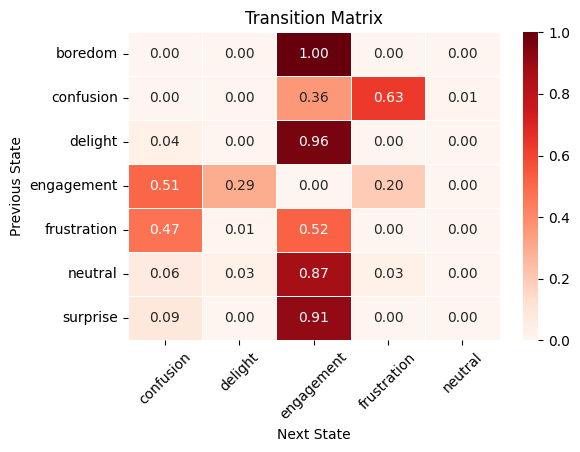

In [53]:
dfs_prob = {
    'model1_prob': model1_prob,
    'model2_prob': model2_prob
}

for name, df in dfs_prob.items():
  matrix_prob = df.pivot(index='current_state', columns='next_state', values='probability').fillna(0)
  print(f"{70*'*'}\n{name}\n{70*'*'}\n{matrix_prob}\n")
  heatmap(matrix_prob, 'Next State', 'Previous State')

### exclude_self_transition=False

In [54]:
exper1_prob_False = compute_probability(df_exper1, 'previous_state', 'next_state', exclude_self_transition=False)
exper2_prob_False = compute_probability(df_exper2, 'previous_state', 'next_state', exclude_self_transition=False)

# Date 03/01/2025
model1_prob_False = compute_probability(df_model1, 'current_state', 'next_state', exclude_self_transition=False)
model2_prob_False = compute_probability(df_model2, 'current_state', 'next_state', exclude_self_transition=False)

**********************************************************************
exper1_prob
**********************************************************************
next_state      confusion   delight  engagement  frustration  neutral
previous_state                                                       
confusion        0.096386  0.024096    0.746988     0.132530  0.00000
delight          0.071429  0.119048    0.785714     0.000000  0.02381
engagement       0.136283  0.061947    0.753982     0.047788  0.00000
frustration      0.135135  0.081081    0.702703     0.081081  0.00000
neutral          0.000000  0.000000    1.000000     0.000000  0.00000



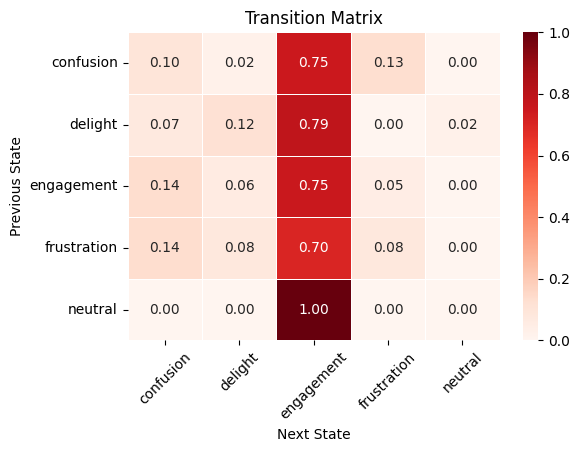

**********************************************************************
exper2_prob
**********************************************************************
next_state      confusion   delight  engagement  frustration
previous_state                                              
confusion        0.417582  0.010989    0.428571     0.142857
delight          0.025000  0.325000    0.650000     0.000000
engagement       0.104089  0.050186    0.797398     0.048327
frustration      0.186441  0.000000    0.271186     0.542373
neutral          0.000000  0.000000    1.000000     0.000000



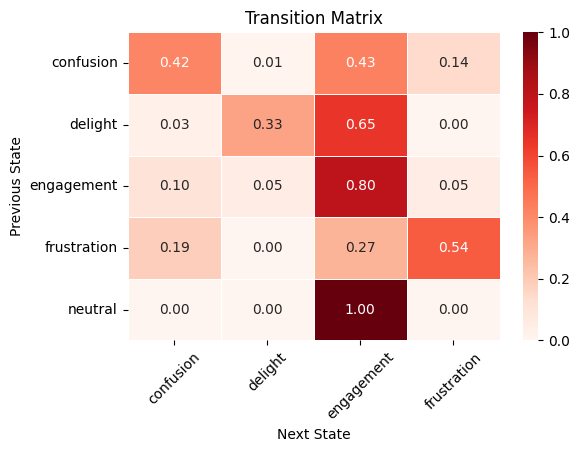

In [55]:
dfs_prob_exper = {
    'exper1_prob': exper1_prob_False,
    'exper2_prob': exper2_prob_False
}
for name, df in dfs_prob_exper.items():
  matrix_prob = df.pivot(index='previous_state', columns='next_state', values='probability').fillna(0)
  print(f"{70*'*'}\n{name}\n{70*'*'}\n{matrix_prob}\n")
  heatmap(matrix_prob, 'Next State', 'Previous State')

**********************************************************************
model1_prob
**********************************************************************
next_state     confusion   delight  engagement  frustration   neutral
current_state                                                        
boredom         0.000000  0.000000    1.000000     0.000000  0.000000
confusion       0.022901  0.022901    0.755725     0.190840  0.007634
delight         0.119048  0.190476    0.678571     0.011905  0.000000
engagement      0.159213  0.069767    0.745975     0.025045  0.000000
frustration     0.137931  0.068966    0.724138     0.051724  0.017241
neutral         0.078947  0.052632    0.842105     0.000000  0.026316
surprise        0.111111  0.037037    0.851852     0.000000  0.000000



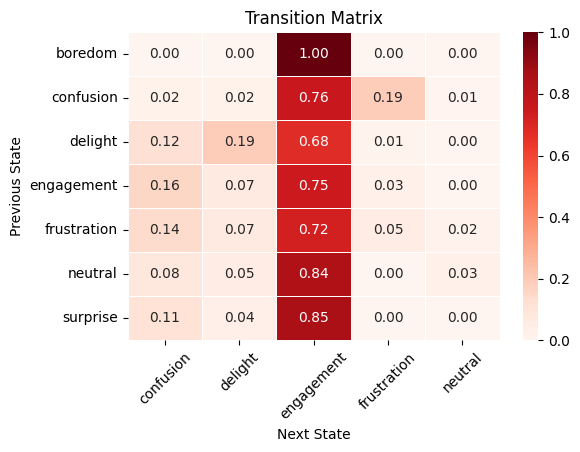

**********************************************************************
model2_prob
**********************************************************************
next_state     confusion   delight  engagement  frustration   neutral
current_state                                                        
boredom         0.000000  0.000000    1.000000     0.000000  0.000000
confusion       0.000000  0.000000    0.362903     0.629032  0.008065
delight         0.030769  0.123077    0.846154     0.000000  0.000000
engagement      0.118474  0.068273    0.767068     0.046185  0.000000
frustration     0.315789  0.006579    0.348684     0.328947  0.000000
neutral         0.064516  0.032258    0.870968     0.032258  0.000000
surprise        0.086957  0.000000    0.913043     0.000000  0.000000



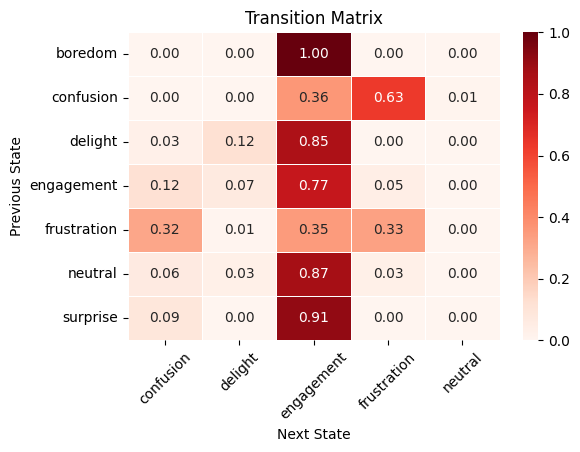

In [58]:
dfs_prob_model_False = {
    'model1_prob': model1_prob_False,
    'model2_prob': model2_prob_False
}

for name, df in dfs_prob_model_False.items():
  matrix_prob = df.pivot(index='current_state', columns='next_state', values='probability').fillna(0)
  print(f"{70*'*'}\n{name}\n{70*'*'}\n{matrix_prob}\n")
  heatmap(matrix_prob, 'Next State', 'Previous State')

All edges (with attributes): [('neutral', 'engagement', 12, {'prob': 1.0}), ('confusion', 'delight', 0, {'prob': 0.02666666666666667}), ('confusion', 'engagement', 1, {'prob': 0.8266666666666667}), ('confusion', 'frustration', 2, {'prob': 0.14666666666666667}), ('frustration', 'confusion', 9, {'prob': 0.14705882352941177}), ('frustration', 'delight', 10, {'prob': 0.08823529411764706}), ('frustration', 'engagement', 11, {'prob': 0.7647058823529411}), ('delight', 'confusion', 3, {'prob': 0.08108108108108109}), ('delight', 'engagement', 4, {'prob': 0.8918918918918919}), ('delight', 'neutral', 5, {'prob': 0.02702702702702703}), ('engagement', 'confusion', 6, {'prob': 0.5539568345323741}), ('engagement', 'delight', 7, {'prob': 0.2517985611510791}), ('engagement', 'frustration', 8, {'prob': 0.19424460431654678})]


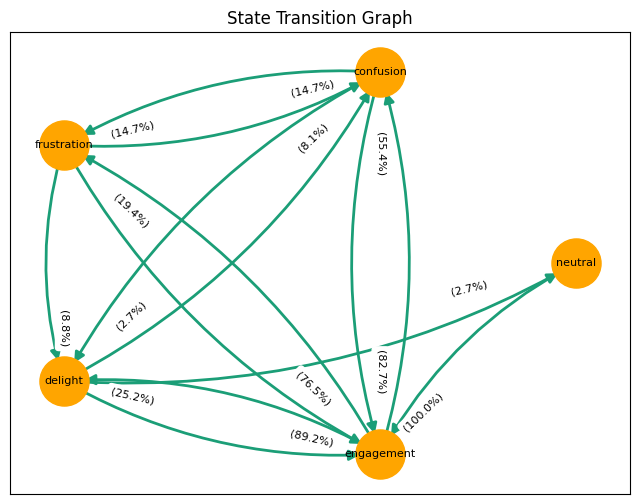

All edges (with attributes): [('neutral', 'engagement', 10, {'prob': 1.0}), ('confusion', 'delight', 0, {'prob': 0.018867924528301886}), ('confusion', 'engagement', 1, {'prob': 0.7358490566037735}), ('confusion', 'frustration', 2, {'prob': 0.24528301886792453}), ('frustration', 'confusion', 8, {'prob': 0.4074074074074074}), ('frustration', 'engagement', 9, {'prob': 0.5925925925925926}), ('delight', 'confusion', 3, {'prob': 0.037037037037037035}), ('delight', 'engagement', 4, {'prob': 0.9629629629629629}), ('engagement', 'confusion', 5, {'prob': 0.5137614678899083}), ('engagement', 'delight', 6, {'prob': 0.24770642201834864}), ('engagement', 'frustration', 7, {'prob': 0.23853211009174313})]


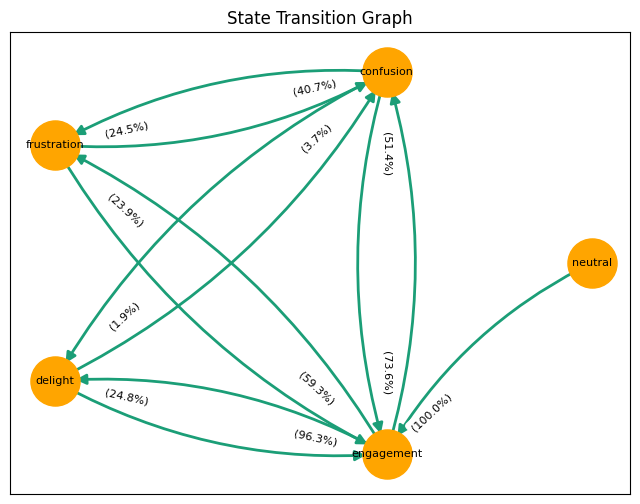

In [ ]:
network_graph(exper1_transition_prob, 'previous_state', 'next_state', 'probability')
network_graph(exper2_transition_prob, 'previous_state', 'next_state', 'probability')

# D'Mello - Transition likelihoods for Study 1

In [119]:
def compute_transition_statistics(transition_data, state_counts):
    """
    Compute transition statistics for a given set of transitions.

    Parameters:
    - transition_data (dict): A dictionary where keys are transitions (e.g., 'Flow -> Con') and values are lists
      containing the count of transitions and the list of individual transition counts.
    - state_counts (dict): A dictionary where keys are states (e.g., 'Flow') and values are the total number of occurrences
      of that state as the current state.

    Returns:
    - pd.DataFrame: A DataFrame containing the transition statistics.
    """
    results = []

    for transition, (transition_count, transition_counts_list) in transition_data.items():
        current_state, next_state = transition.split(' -> ')
        N = transition_count
        M = N / state_counts[current_state]
        SD = np.std(transition_counts_list, ddof=1)  # Sample standard deviation
        t_stat = M / (SD / np.sqrt(N))
        df_value = N - 1
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df_value))
        d_value = M / SD

        results.append({
            'Transition': transition,
            'N': N,
            'M': M,
            'SD': SD,
            't': t_stat,
            'df': df_value,
            'p': p_value,
            'd': d_value
        })

    return pd.DataFrame(results)


# Sample data
data = {
    'Current State': ['Flow', 'Confusion', 'Frustration', 'Boredom', 'Delight', 'Surprise', 'Neutral'],
    'Flow': [0, 116, 62, 71, 20, 22, 75],
    'Confusion': [120, 0, 62, 50, 18, 18, 83],
    'Frustration': [61, 70, 0, 49, 6, 9, 49],
    'Boredom': [72, 44, 51, 0, 5, 7, 107],
    'Delight': [22, 13, 7, 5, 0, 6, 31],
    'Surprise': [21, 14, 9, 3, 5, 0, 21],
    'Neutral': [72, 95, 49, 103, 30, 15, 0]
}

df = pd.DataFrame(data)
df.set_index('Current State', inplace=True)

# Compute transition probabilities
transition_counts = df.values
row_sums = transition_counts.sum(axis=1, keepdims=True)
transition_probs = transition_counts / row_sums
transition_probs_df = pd.DataFrame(transition_probs, columns=df.columns, index=df.index)

# Initialize lists to store t-statistics and p-values
t_stats_list = []
p_values_list = []

# Perform t-tests for each transition probability
for current_state in transition_probs_df.index:
    for next_state in transition_probs_df.columns:
        prob = transition_probs_df.at[current_state, next_state]
        t_stat, p_value = stats.ttest_1samp([prob], 0)  # One-sample t-test against 0
        t_stats_list.append(t_stat)
        p_values_list.append(p_value)

# Convert lists to DataFrames
t_stats_df = pd.DataFrame(np.array(t_stats_list).reshape(transition_probs_df.shape),
                           columns=transition_probs_df.columns,
                           index=transition_probs_df.index)
p_values_df = pd.DataFrame(np.array(p_values_list).reshape(transition_probs_df.shape),
                            columns=transition_probs_df.columns,
                            index=transition_probs_df.index)

# Display the results
print("Transition Probabilities (M):")
print(transition_probs_df)
print("\nT-Statistics (t):")
print(t_stats_df)
print("\nP-Values (p):")
print(p_values_df)


Transition Probabilities (M):
                   Flow  Confusion  Frustration   Boredom   Delight  Surprise  \
Current State                                                                   
Flow           0.000000   0.326087     0.165761  0.195652  0.059783  0.057065   
Confusion      0.329545   0.000000     0.198864  0.125000  0.036932  0.039773   
Frustration    0.258333   0.258333     0.000000  0.212500  0.029167  0.037500   
Boredom        0.252669   0.177936     0.174377  0.000000  0.017794  0.010676   
Delight        0.238095   0.214286     0.071429  0.059524  0.000000  0.059524   
Surprise       0.285714   0.233766     0.116883  0.090909  0.077922  0.000000   
Neutral        0.204918   0.226776     0.133880  0.292350  0.084699  0.057377   

                Neutral  
Current State            
Flow           0.195652  
Confusion      0.269886  
Frustration    0.204167  
Boredom        0.366548  
Delight        0.357143  
Surprise       0.194805  
Neutral        0.000000  

T-Sta

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [120]:
pd.DataFrame(transition_probs_df)

,Flow,Confusion,Frustration,Boredom,Delight,Surprise,Neutral
Current State,,,,,,,
Flow,0.000000,0.326087,0.165761,0.195652,0.059783,0.057065,0.195652
Confusion,0.329545,0.000000,0.198864,0.125000,0.036932,0.039773,0.269886
Frustration,0.258333,0.258333,0.000000,0.212500,0.029167,0.037500,0.204167
Boredom,0.252669,0.177936,0.174377,0.000000,0.017794,0.010676,0.366548
Delight,0.238095,0.214286,0.071429,0.059524,0.000000,0.059524,0.357143
Surprise,0.285714,0.233766,0.116883,0.090909,0.077922,0.000000,0.194805
Neutral,0.204918,0.226776,0.133880,0.292350,0.084699,0.057377,0.000000


In [ ]:
def compute_transition_statistics(data):
    # Compute transition counts
    transition_counts = data.groupby(['current_state', 'next_state']).size().reset_index(name='transition_count')

    # Compute the total number of observations
    total_observations = len(data)

    # Calculate transition probabilities (M)
    transition_counts['M'] = transition_counts['transition_count'] / total_observations

    # Calculate standard deviation (SD) of transition counts
    transition_counts['SD'] = transition_counts.groupby(['current_state', 'next_state'])['transition_count'].transform(np.std, ddof=0)

    # Calculate degrees of freedom (df)
    transition_counts['N'] = transition_counts.groupby(['current_state', 'next_state'])['transition_count'].transform('count')
    transition_counts['df'] = transition_counts['N'] - 1

    # Calculate t-statistic
    transition_counts['t'] = transition_counts['M'] / (transition_counts['SD'] / np.sqrt(transition_counts['N']))

    # Calculate p-value
    transition_counts['p'] = transition_counts.apply(lambda row: stats.t.sf(abs(row['t']), row['df']) * 2, axis=1)

    # Calculate effect size (d)
    transition_counts['d'] = transition_counts['M'] / transition_counts['SD']

    # Select relevant columns for output
    result = transition_counts[['current_state', 'next_state', 'N', 'M', 'SD', 't', 'df', 'p', 'd']]

    return result

# Example usage:
# Assuming 'data_model1' is your DataFrame containing 'current_state' and 'next_state' columns
# transition_stats = compute_transition_statistics(data_model1)
# print(transition_stats)
df = pd.DataFrame(data)
df.set_index('Current State', inplace=True)
transition_counts = df.values
row_sums = transition_counts.sum(axis=1, keepdims=True)
transition_probs = transition_counts / row_sums
transition_probs_df = pd.DataFrame(transition_probs, columns=df.columns, index=df.index)
